In [1]:
import os
import mat73
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
from datetime import datetime
plt.rcParams["font.family"] = "Times New Roman"
plt.rcParams.update({'font.size': 12})
plt.rcParams.update({'font.style': 'oblique'})
data_path = "/Users/yaoling/OneDrive - NTNU/MASCOT_PhD/Data/Porto/D2_3D_salinity-021.mat"
os.system("say It will take a long time to import data")
sal_data = mat73.loadmat(data_path)
os.system('say Finished Data importing')
print("Everything works fine")

Everything works fine


In [2]:
def filterNaN(val):
    temp = []
    for i in range(len(val)):
        if not np.isnan(val[i]):
            temp.append(val[i])
    val = np.array(temp).reshape(-1, 1)
    return val

# filter data to remove NaN
lon = sal_data['data']["X"][:, :, 0]
lat = sal_data['data']['Y'][:, :, 0]
depth = sal_data['data']['Z'][0, :, :, 0]
timestamp = (sal_data['data']['Time'] - 719529) * 24 * 3600

# filtered data
lon_f = filterNaN(lon.reshape(-1, 1))
lat_f = filterNaN(lat.reshape(-1, 1))

In [3]:
# trend is set by time average
S = np.mean(sal_data['data']['Val'][:, :, :, 0], axis=0)
S_f = filterNaN(S.reshape(-1, 1)) # filtered salinity

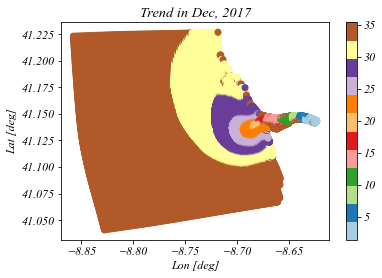

In [11]:
# plot the trend
def plotf(lat, lon, color, title, string):
    plt.scatter(lon, lat, c = color, cmap = "Paired")
    plt.title(title)
    plt.xlabel("Lon [deg]")
    plt.ylabel("Lat [deg]")
    plt.colorbar()
    figpath = "/Users/yaoling/OneDrive - NTNU/MASCOT_PhD/Missions/Porto/Delft3D/fig/"
    plt.savefig(figpath + string + ".pdf")
    plt.show()

plotf(lat_f, lon_f, S_f, "Trend in Dec, 2017", "test")


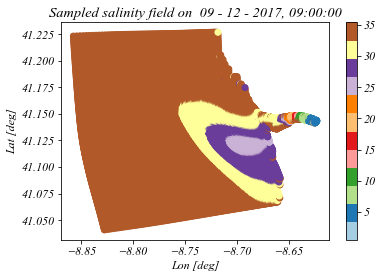

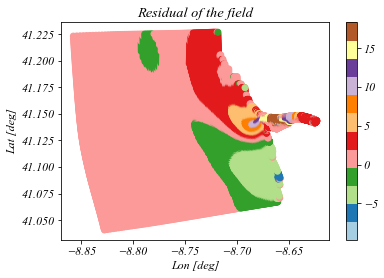

In [12]:
# Randomly sample one frame to compare the residual and to find the correlation range
ind_sample = 400
S_sample = filterNaN(sal_data['data']['Val'][ind_sample, :, :, 0].reshape(-1, 1))
residual = S_sample - S_f

plotf(lat_f, lon_f, S_sample, "Sampled salinity field on " + datetime.fromtimestamp(timestamp[ind_sample]).strftime(" %d - %m - %Y, %H:%M:%S"), "sample"),
plotf(lat_f, lon_f, residual, "Residual of the field", "residual")

/usr/local/lib/python3.9/site-packages/scikit_gstat-0.5.4-py3.9.egg/skgstat/plotting/variogram_plot.py:96: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


spherical Variogram
-------------------
Estimator:         matheron
Effective Range:   669.79
Sill:              24.54
Nugget:            0.00
        


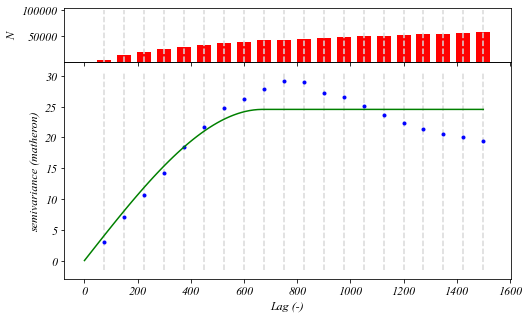

In [14]:
# Convert lat lon to x y, where x is pointing north, y is pointing east, and depth is z
lat_origin, lon_origin = 41.10251, -8.669811
circumference = 40075000
def deg2rad(deg):
    return deg / 180 * np.pi
def rad2deg(rad):
    return rad / np.pi * 180
def latlon2xy(lat, lon, lat_origin, lon_origin):
    x = deg2rad(lat - lat_origin) / 2 / np.pi * circumference
    y = deg2rad(lon - lon_origin) / 2 / np.pi * circumference * np.cos(deg2rad(lat))
    # x_, y_ = self.R.T @ np.vstack(x, y) # convert it back
    return x, y
x, y = latlon2xy(lat_f, lon_f, lat_origin, lon_origin)

# compute the variogram
from skgstat import Variogram
ind = np.random.randint(0, x.shape[0] - 1, size = 5000) # take out only 5000 random locations, otherwise it takes too long to run
V_v = Variogram(coordinates = np.hstack((x[ind], y[ind])), values = residual[ind].squeeze(), n_lags = 20, maxlag = 1500, use_nugget=True)
# V_v.fit_method = 'trf' # moment method
fig = V_v.plot(hist = True)
fig.savefig("test1.pdf")
print(V_v)

# plt.figure()
# plotf(lat_f[ind], lon_f[ind], S_f[ind], "Sampled trend")
# plt.figure()
# plotf(lat_f[ind], lon_f[ind], S_sample[ind], "Sampled sample")
# plt.figure()
# plotf(lat_f[ind], lon_f[ind], residual[ind], "Sampled residual")